Training RNNs on ODR
====================



## Notebook Settings



In [1]:
%load_ext autoreload
  %autoreload 2
  %reload_ext autoreload

  %run ../notebooks/setup.py
  %matplotlib inline
  %config InlineBackend.figure_format = 'png'

  REPO_ROOT = "/home/leon/models/NeuroFlame"
  pal = sns.color_palette("tab10")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import torch
  import torch.nn as nn
  import torch.optim as optim
  import torchmetrics
  import torch.nn.functional as F
  from torch.utils.data import Dataset, TensorDataset, DataLoader

  DEVICE = 'cuda:0'

In [1]:
import sys
  sys.path.insert(0, '../')

  import pandas as pd
  import torch.nn as nn
  from time import perf_counter
  from scipy.stats import circmean

  from src.network import Network
  from src.plot_utils import plot_con
  from src.decode import decode_bump, circcvl, decode_bump_torch
  from src.lr_utils import masked_normalize, clamp_tensor, normalize_tensor

## Helpers



### plots



In [1]:
def plot_rates_selec(rates, idx=0, thresh=0.5, figname='fig.svg'):
        fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
        r_max = thresh * np.max(rates[idx])

        ax[0].imshow(rates[idx].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max)
        ax[0].set_ylabel('Neuron #')
        ax[0].set_xlabel('Step')

        plt.savefig(figname, dpi=300)
        plt.show()

In [1]:
def plot_m0_m1_phi(rates, idx, figname='fig.svg'):

      # m0, m1, phi = decode_bump(rates, axis=-1)
      m0, m1, phi = get_fourier_moments(rates, axis=-1)
      fig, ax = plt.subplots(1, 3, figsize=[2*width, height])

      ax[0].plot(m0.T)
      #ax[0].set_ylim([0, 360])
      #ax[0].set_yticks([0, 90, 180, 270, 360])
      ax[0].set_ylabel('$\mathcal{F}_0$ (Hz)')
      ax[0].set_xlabel('Step')

      ax[1].plot(m1.T)
      # ax[1].set_ylim([0, 360])
      # ax[1].set_yticks([0, 90, 180, 270, 360])
      ax[1].set_ylabel('$\mathcal{F}_1$ (Hz)')
      ax[1].set_xlabel('Step')

      ax[2].plot(phi.T * 180 / np.pi, alpha=.5)
      ax[2].set_ylim([0, 360])
      ax[2].set_yticks([0, 90, 180, 270, 360])
      ax[2].set_ylabel('Phase (°)')
      ax[2].set_xlabel('Step')

      plt.savefig(figname, dpi=300)
      plt.show()

### Data Split



In [1]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

  def split_data(X, Y, train_perc=0.8, batch_size=32):

     X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                         train_size=train_perc,
                                                         stratify=Y[:, 0].cpu().numpy(),
                                                         shuffle=True)

     print(X_train.shape, X_test.shape)
     print(Y_train.shape, Y_test.shape)

     train_dataset = TensorDataset(X_train, Y_train)
     val_dataset = TensorDataset(X_test, Y_test)

     # Create data loaders
     train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
     val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

     return train_loader, val_loader

### Optimization



In [1]:
def training_step(dataloader, model, loss_fn, optimizer, penalty=None, lbd=.001, clip_grad=0, zero_grad=0):
      device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")

      model.train()
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)

          optimizer.zero_grad()

          rates = model(X)
          loss = loss_fn(rates, y)

          if penalty is not None:
              reg_loss = 0
              for param in model.parameters():
                  if penalty=='l1':
                      reg_loss += torch.sum(torch.abs(param))
                  else:
                      reg_loss += torch.sum(torch.square(param))

                  loss = loss + lbd * reg_loss

          # Backpropagation
          loss.backward()

          # Clip gradients
          if clip_grad:
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
              #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

          optimizer.step()

      return loss

In [1]:
def validation_step(dataloader, model, loss_fn):
      size = len(dataloader.dataset)
      num_batches = len(dataloader)

      device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")

      # Validation loop.
      model.eval()
      val_loss = 0.0

      with torch.no_grad():
          for X, y in dataloader:
              X, y = X.to(device), y.to(device)

              rates = model(X)
              loss = loss_fn(rates, y)

              val_loss += loss.item() * X.size(0)

          val_loss /= size
      return val_loss

In [1]:
def optimization(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100, penalty=None, lbd=1, thresh=.005, zero_grad=0):
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
      # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)
      # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

      device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
      model.to(device)

      loss_list = []
      val_loss_list = []
      accuracies = []
      angle_list = []

      for epoch in range(num_epochs):
          loss = training_step(train_loader, model, loss_fn, optimizer, penalty, lbd, zero_grad=zero_grad)
          val_loss = validation_step(val_loader, model, loss_fn)

          scheduler.step(val_loss)

          loss_list.append(loss.item())
          val_loss_list.append(val_loss)
          # if epoch % int(num_epochs  / 10) == 0:
          print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

          if val_loss < thresh and loss < thresh:
              print(f'Stopping training as loss has fallen below the threshold: {loss}, {val_loss}')
              break

          if val_loss > 300:
              print(f'Stopping training as loss is too high: {val_loss}')
              break

          if torch.isnan(loss):
              print(f'Stopping training as loss is NaN.')
              break

      return loss_list, val_loss_list

### Loss



In [1]:
import torch
import torch.nn as nn

class NanMeanMSELoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(NanMeanMSELoss, self).__init__()
        self.reduction = reduction

    def forward(self, input, target):
        # Element-wise difference
        diff = input - target

        # Squared difference
        squared_diff = diff ** 2

        # Initialize a tensor to store the errors
        batch_errors = torch.zeros(input.size(0), device=input.device)

        # Compute mean squared error for each batch
        for i in range(input.size(0)):
            batch_mask = ~torch.isnan(input[i])
            if torch.sum(batch_mask) > 0:
                batch_errors[i] = torch.nanmean(squared_diff[i])
            else:
                batch_errors[i] = 0  # Handle case where all values are NaN in the batch

        # Apply reduction method
        if self.reduction == 'mean':
            return torch.mean(batch_errors)
        elif self.reduction == 'sum':
            return torch.sum(batch_errors)
        else:
            return batch_errors  # No reduction, return individual batch errors

In [1]:
def get_fourier_moments(signal, axis=-1):
    # Perform the FFT
    fft_coeffs = np.fft.fft(signal, axis=axis)

    # Calculate the zero, first, and second Fourier moments
    zero_moment = fft_coeffs[..., 0]
    first_moment = fft_coeffs[..., 1]

    # Calculate magnitude m0, m1, and m2
    m0 = np.abs(zero_moment) / signal.shape[axis]  # Normalize m0 by the signal length
    m1 = 2.0 * np.abs(first_moment) / signal.shape[axis]

    # Calculate the phase of the signal
    phases = np.angle(first_moment) % (2.0 * torch.pi)

    return m0, m1, phases

In [1]:
def compute_fourier_moments(signal, dim=-1):
    # Perform the FFT
    fft_coeffs = torch.fft.fft(signal, dim=dim)

    # Calculate the zero, first, and second Fourier moments
    zero_moment = fft_coeffs[..., 0]
    first_moment = fft_coeffs[..., 1]
    second_moment = fft_coeffs[..., 2]

    # Calculate magnitude m0, m1, and m2
    m0 = torch.abs(zero_moment) / signal.size(dim)  # Normalize m0 by the signal length
    m1 = 2.0 * torch.abs(first_moment) / signal.size(dim)
    m2 = 2.0 * torch.abs(second_moment) / signal.size(dim)

    # Calculate the phase of the signal
    phases = torch.angle(first_moment) % (2.0 * torch.pi)

    return m0, m1, m2, phases

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AngularErrorLoss(nn.Module):
    def __init__(self, rwd_idx=-1, zero_idx=0, stim_idx=0):
        super(AngularErrorLoss, self).__init__()
        self.loss = nn.SmoothL1Loss()
        self.loss = nn.MSELoss()
        self.loss = NanMeanMSELoss()
        self.rwd_idx = rwd_idx
        self.zero_idx = zero_idx
        self.stim_idx = stim_idx

    def forward(self, readout, targets):
        m0, m1, m2, phi = compute_fourier_moments(readout, dim=-1)

        ones = torch.ones_like(m0[:, self.rwd_idx])
        zeros = torch.zeros_like(m0[:, self.zero_idx])

        # Compute the angular difference
        # predicted_angles = phi[:, self.rwd_idx]
        # angular_diff = torch.atan2(torch.sin(predicted_angles - targets), torch.cos(predicted_angles - targets))
        # # Compute Smooth L1 Loss based on angular differences
        # loss_angular = self.loss(angular_diff, torch.zeros_like(angular_diff))

        predicted_sin = torch.sin(phi[:, self.rwd_idx])
        predicted_cos = torch.cos(phi[:, self.rwd_idx])

        target_sin = torch.sin(targets)
        target_cos = torch.cos(targets)

        loss_sin = self.loss(predicted_sin, target_sin)
        loss_cos = self.loss(predicted_cos, target_cos)
        loss_angular = (loss_sin + loss_cos) / 2

        # Regularization losses
        loss_zero = self.loss(m1[:, self.zero_idx], zeros)
        regularization = F.relu(ones - m1[:, self.rwd_idx] / m0[:, self.rwd_idx]).mean()

        # Combine losses
        total_loss = loss_angular + loss_zero + regularization

        return total_loss

In [1]:
import torch
  import torch.nn as nn
  import torch.nn.functional as F

  class AngularErrorLoss2(nn.Module):
      def __init__(self, rwd_idx=-1, zero_idx=0, stim_idx=0):
          super(AngularErrorLoss, self).__init__()
          self.mse_loss = nn.MSELoss()
          self.loss = nn.SmoothL1Loss()

          self.rwd_idx = rwd_idx
          self.zero_idx = zero_idx
          self.stim_idx = stim_idx

      def forward(self, readout, targets):
          # m0, m1 , phi = decode_bump_torch(readout)
          m0, m1, m2, phi = compute_fourier_moments(readout, dim=-1)

          ones = torch.ones_like(m0[:, self.rwd_idx])
          zeros = torch.zeros_like(m0[:, self.zero_idx])

          loss = 0

          predicted_sin = torch.sin(phi[:, self.rwd_idx])
          predicted_cos = torch.cos(phi[:, self.rwd_idx])

          target_sin = torch.sin(targets)
          target_cos = torch.cos(targets)

          loss_sin = self.loss(predicted_sin, target_sin)
          loss_cos = self.loss(predicted_cos, target_cos)
          loss += (loss_sin + loss_cos) / 2

          loss += self.loss(m1[:, self.zero_idx], zeros) * len(self.zero_idx)
          # loss += self.loss(m1[:, self.rwd_idx] / m0[:, self.rwd_idx], ones) * len(self.rwd_idx)
          loss += F.relu(ones - m1[:, self.rwd_idx] / m0[:, self.rwd_idx]).mean() * len(self.rwd_idx)
          return loss

### Other



In [1]:
def angle_AB(A, B):
      A_norm = A / (np.linalg.norm(A) + 1e-5)
      B_norm = B / (np.linalg.norm(B) + 1e-5)

      return int(np.arccos(A_norm @ B_norm) * 180 / np.pi)

In [1]:
def convert_seconds(seconds):
      h = seconds // 3600
      m = (seconds % 3600) // 60
      s = seconds % 60
      return h, m, s

## Model



In [1]:
REPO_ROOT = "/home/leon/models/NeuroFlame"
    conf_name = "train_odr_EI.yml"
    DEVICE = 'cuda:0'
    seed = np.random.randint(0, 1e6)
    print(seed)
    N_BATCH = 32

601332

In [1]:
model = Network(conf_name, REPO_ROOT, VERBOSE=0, DEVICE=DEVICE, SEED=seed, N_BATCH=N_BATCH)

In [1]:
print(model.random_shifts.shape)

torch.Size([32])

## Training



#### Parameters



In [1]:
for name, param in model.named_parameters():
      if param.requires_grad:
          print(name, param.shape)

Wab_train torch.Size([500, 500])
J_STP torch.Size([])

Testing the network on steps from sample odor offset to test odor onset



In [1]:
stim_mask = torch.zeros((model.N_BATCH, int((model.N_STEPS-model.N_STEADY) / model.N_WINDOW)), device=DEVICE, dtype=torch.bool)
print('stim_mask', stim_mask.shape)

for j in range(model.N_BATCH):
        # from ith stim onset to stim offset
        mask = torch.arange((model.start_indices[0, j] - model.N_STEADY)/ model.N_WINDOW,
                            (model.end_indices[0, j] - model.N_STEADY) / model.N_WINDOW).to(torch.int)
        stim_mask[j, mask] = True

idx = np.random.randint(32)
print(torch.where(stim_mask[0]==1)[0])
stim_mask = stim_mask.repeat(N_TARGETS, 1)
print('stim_mask', stim_mask.shape)
print(torch.where(stim_mask[32]==1)[0])

stim_mask torch.Size([32, 81])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], device='cuda:0')
# [goto error]
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[104], line 12
     10 idx = np.random.randint(32)
     11 print(torch.where(stim_mask[0]==1)[0])
---> 12 print(torch.where(stim_mask[32]==1)[0])
     13 stim_mask = stim_mask.repeat(N_TARGETS, 1)
     14 print('stim_mask', stim_mask.shape)
:
IndexError: index 32 is out of bounds for dimension 0 with size 32

In [1]:
rwd_mask = torch.zeros((model.N_BATCH, int((model.N_STEPS-model.N_STEADY) / model.N_WINDOW)), device=DEVICE, dtype=torch.bool)
print('rwd_mask', rwd_mask.shape)

for i in range(model.N_BATCH):
    # from first stim onset to second stim onset
    mask = torch.arange((model.start_indices[0, i] - model.N_STEADY)/ model.N_WINDOW,
                        (model.start_indices[1, i] - model.N_STEADY) / model.N_WINDOW).to(torch.int)
    # print(mask)
    rwd_mask[i, mask] = True

idx = np.random.randint(32)
print(torch.where(rwd_mask[idx]==1)[0])
# model.lr_eval_win = torch.max(torch.sum(rwd_mask==1, axis=-1))

rwd_mask = rwd_mask.repeat(N_TARGETS, 1)
print('rwd_mask', rwd_mask.shape)

rwd_mask torch.Size([32, 81])
tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58], device='cuda:0')
rwd_mask torch.Size([256, 81])

In [1]:
zero_mask = torch.zeros((model.N_BATCH, int((model.N_STEPS-model.N_STEADY) / model.N_WINDOW)), device=DEVICE, dtype=torch.bool)
print('zero_mask', zero_mask.shape)

for i in range(model.N_BATCH):
    mask = ~rwd_mask[i]
    zero_mask[i, mask] = True

idx = np.random.randint(32)
print(torch.where(zero_mask[idx]==1)[0])

zero_mask = zero_mask.repeat(N_TARGETS, 1)
print('zero_mask', zero_mask.shape)

zero_mask torch.Size([32, 81])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
        80], device='cuda:0')
zero_mask torch.Size([256, 81])

In [1]:
steps = np.arange(0, model.N_STEPS - model.N_STEADY, model.N_WINDOW)

# mask = (steps >= (model.N_STIM_OFF[0] - model.N_STEADY)) & (steps <= (model.N_STEPS - model.N_STEADY))
stim_mask = (steps >= (model.N_STIM_ON[0].cpu().numpy() - model.N_STEADY)) & (steps <= (model.N_STIM_OFF[0].cpu().numpy() - model.N_STEADY))

stim_idx = np.where(stim_mask)[0]
print('stim', stim_idx)

mask = (steps >= (model.N_STIM_ON[0].cpu().numpy() - model.N_STEADY)) & (steps <= (model.N_STIM_ON[1].cpu().numpy() - model.N_STEADY))
rwd_idx = np.where(mask)[0]
print('rwd', rwd_idx)

model.lr_eval_win = rwd_idx.shape[0]

stim_mask = (steps >= (model.N_STIM_ON[0].cpu().numpy() - model.N_STEADY)) & (steps <= (model.N_STIM_ON[1].cpu().numpy() - model.N_STEADY))

# stim_mask = (steps >= (model.N_STIM_ON[0] - model.N_STEADY))

zero_idx = np.where(~mask & ~stim_mask )[0]
print('zero', zero_idx)

stim [10 11 12 13 14 15 16 17 18 19 20]
rwd [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40]
zero [ 0  1  2  3  4  5  6  7  8  9 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80]

#### Inputs and Labels



In [1]:
N_TARGETS = 8
phase_list = np.linspace(0, 360, N_TARGETS+1)[:-1]
print(phase_list)

[  0.  45.  90. 135. 180. 225. 270. 315.]

In [1]:
print(model.PHI0.shape)

torch.Size([32, 1, 1])

In [1]:
ff_input = []
labels = []

model.PHI0 = torch.ones((N_BATCH, 2, 1), device=DEVICE, dtype=torch.float)

for i in range(len(phase_list)):
    model.PHI0[:, 0] = phase_list[i]
    labels.append(torch.ones((model.N_BATCH, int((model.N_STEPS-model.N_STEADY) / model.N_WINDOW)),
                             device=DEVICE, dtype=torch.float) * phase_list[i] * torch.pi / 180.0)

    ff_input.append(model.init_ff_input())

labels = torch.vstack(labels)
ff_input = torch.vstack(ff_input)
print('ff_input', ff_input.shape, 'labels', labels.shape)

ff_input torch.Size([256, 455, 1000]) labels torch.Size([256, 81])

#### Run



In [1]:
batch_size = 32
  train_loader, val_loader = split_data(ff_input, labels, train_perc=0.8, batch_size=batch_size)

torch.Size([3276, 355, 1000]) torch.Size([820, 355, 1000])
torch.Size([3276, 31]) torch.Size([820, 31])

In [1]:
criterion = AngularErrorLoss(rwd_idx=rwd_idx, zero_idx=zero_idx, stim_idx=stim_idx)
  # SGD, Adam, Adam
  learning_rate = 0.1
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [1]:
num_epochs = 15
  start = perf_counter()
  loss, val_loss = optimization(model, train_loader, val_loader, criterion, optimizer, num_epochs)
  end = perf_counter()
  print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

#+begin_example
Epoch 1/15, Training Loss: 0.4322, Validation Loss: 0.3840
Epoch 2/15, Training Loss: 0.3004, Validation Loss: 0.2392
Epoch 3/15, Training Loss: 0.1372, Validation Loss: 0.1361
Epoch 4/15, Training Loss: 0.0971, Validation Loss: 0.0958
Epoch 5/15, Training Loss: 0.1107, Validation Loss: 0.0899
Epoch 6/15, Training Loss: 0.0808, Validation Loss: 0.0764
Epoch 7/15, Training Loss: 0.0952, Validation Loss: 0.0710
Epoch 8/15, Training Loss: 0.0651, Validation Loss: 0.0665
Epoch 9/15, Training Loss: 0.0670, Validation Loss: 0.0625
Epoch 10/15, Training Loss: 0.0638, Validation Loss: 0.0586
Epoch 11/15, Training Loss: 0.0482, Validation Loss: 0.0551
Epoch 12/15, Training Loss: 0.0635, Validation Loss: 0.0598
Epoch 13/15, Training Loss: 0.0445, Validation Loss: 0.0501
#+end_example

In [1]:
torch.save(model.state_dict(), 'models/odr.pth')

437b39c2-4e9b-4e67-9d42-bda848bb1670

## Testing



In [1]:
# model_state_dict = torch.load('models/odr.pth')
# model = Network(conf_name, REPO_ROOT, VERBOSE=0, DEVICE=DEVICE, SEED=seed, N_BATCH=4)
# model.load_state_dict(model_state_dict)

In [1]:
model.eval()

Network(
  (dropout): Dropout(p=0.5, inplace=False)
)

In [1]:
print(phase_list)

[  0.  45.  90. 135. 180. 225. 270. 315.]

In [1]:
model.N_BATCH = 8

  ff_input = []
  labels = []

  model.PHI0 = torch.ones((1, model.PHI0.shape[-1]), device=DEVICE, dtype=torch.float)

  for i in range(len(phase_list)):
      model.PHI0[0] = phase_list[i]
      ff_input.append(model.init_ff_input())

ff_input = torch.vstack(ff_input)
print('ff_input', ff_input.shape)

ff_input torch.Size([64, 355, 1000])

In [1]:
print(model.PHI0)

In [1]:
rates = model.forward(ff_input=ff_input).cpu().detach().numpy()
  print('rates', rates.shape)

rates (64, 61, 500)

In [1]:
print(ff_input.shape)

torch.Size([64, 355, 1000])

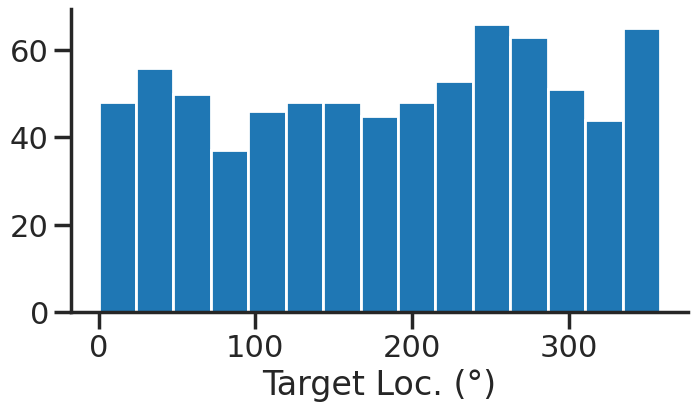

In [1]:
plot_rates_selec(rates=ff_input.cpu().detach().numpy(), idx=20, thresh=.5)

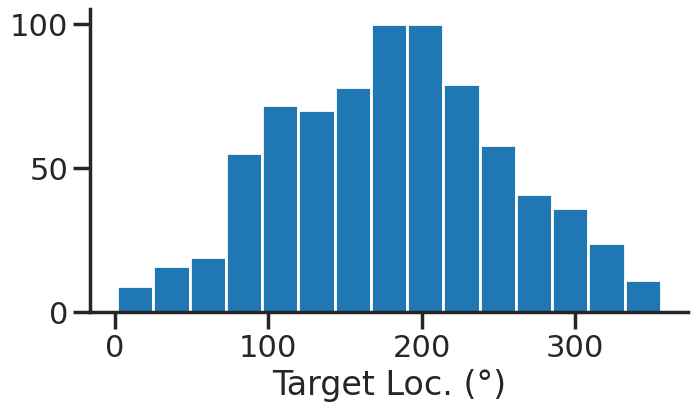

In [1]:
plot_m0_m1_phi(ff_input.cpu().numpy()[..., model.slices[0]], 10)

In [1]:
m0, m1, phi = decode_bump(ff_input.cpu().numpy()[..., model.slices[0]], axis=-1)

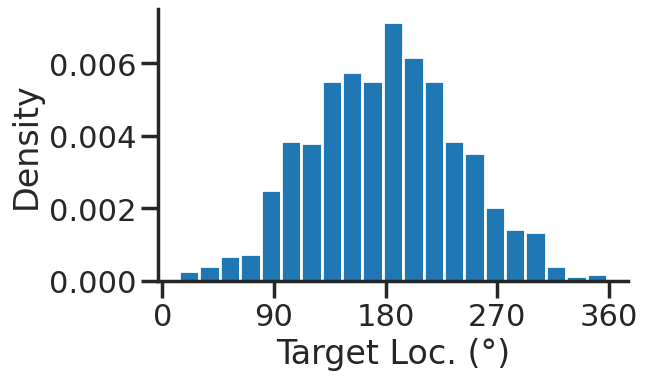

In [1]:
plot_rates_selec(rates, idx=30, thresh=.2)

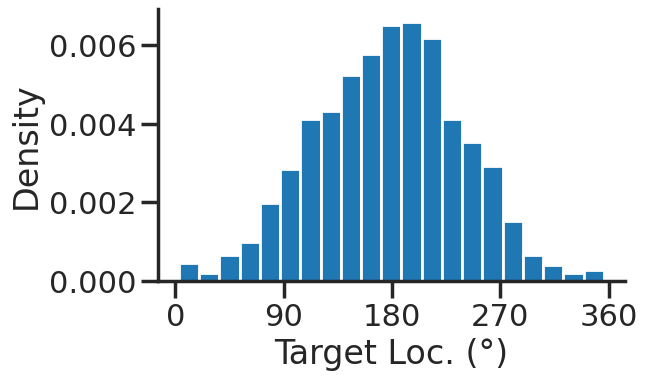

In [1]:
plot_m0_m1_phi(rates, 3)